In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from typing import List, Dict, Optional, Union, Tuple
import os
import logging
from google.cloud import bigquery

# For local VS Code authentication, use Application Default Credentials
# Make sure you've run: gcloud auth application-default login
# Or set GOOGLE_APPLICATION_CREDENTIALS environment variable

# Parameters
bq_project = 'syb-production-analytics'

# Configure logging for production environments
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [4]:
query = f"""
WITH paying_zone_measures AS (
  SELECT
    measure,
    partition_date,
    SUM(value) AS value
  FROM `syb-production-analytics.StatisticalProcessControl.SPCKeyMetricsDaily`
  WHERE measure LIKE '%nr_paying_sound_zones'
    AND measure NOT LIKE '%__eo%'
  GROUP BY ALL
),

max_date AS (
  SELECT MAX(partition_date) AS partition_date
  FROM paying_zone_measures
),

dim_measure AS (
  SELECT measure
  FROM paying_zone_measures
  GROUP BY 1
)

SELECT
  SPLIT(dm.measure, 'day__')[SAFE_OFFSET(1)] AS measure,
  partition_date,
  COALESCE(pzm.value, 0) AS value
FROM dim_measure dm
CROSS JOIN max_date md
CROSS JOIN
  UNNEST(
    GENERATE_DATE_ARRAY(
      DATE_ADD(md.partition_date, INTERVAL - 27 DAY),
      md.partition_date
    )
  ) AS partition_date
LEFT JOIN paying_zone_measures pzm USING (
  measure,
  partition_date
)
"""

In [5]:
client = bigquery.Client(bq_project)
df = client.query(query).to_dataframe()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [18]:
class SPCAnalyzer:
    """
    A production-ready class for Statistical Process Control (SPC) analysis.
    Implements XmR (Individuals & Moving Range) Charts with Western Electric Rules.
    """

    def __init__(self, df: pd.DataFrame, value_col: str = 'value', date_col: str = 'partition_date'):
        self.df = df.copy()
        self.value_col = value_col
        self.date_col = date_col
        self._validate_columns()
        self._preprocess_data()

    def _validate_columns(self):
        missing = [col for col in [self.value_col, self.date_col] if col not in self.df.columns]
        if missing:
            raise ValueError(f"Missing required columns in DataFrame: {missing}")

    def _preprocess_data(self):
        """Ensures types are correct and data is sorted by date."""
        self.df[self.date_col] = pd.to_datetime(self.df[self.date_col])
        self.df[self.value_col] = pd.to_numeric(self.df[self.value_col], errors='coerce')
        self.df = self.df.sort_values(self.date_col)

    def _calculate_limits(self, series: pd.Series) -> Dict[str, float]:
        """
        Calculates limits for X chart and MR chart using Moving Range methodology.
        Constants for n=2: d2 = 1.128, D4 = 3.267
        """
        # 1. Calculate Moving Range
        mr_series = series.diff().abs()

        # 2. Calculate Averages
        mean_x = series.mean()
        mean_mr = mr_series.mean()

        # 3. Estimate Sigma (MR-bar / d2)
        sigma_est = mean_mr / 1.128 if mean_mr != 0 else 0

        # 4. Calculate Limits (No capping at 0)
        ucl_x = mean_x + (3 * sigma_est)
        lcl_x = mean_x - (3 * sigma_est)

        ucl_mr = 3.267 * mean_mr
        lcl_mr = 0.0

        return {
            'mean': mean_x,
            'std': sigma_est,
            'ucl_x': ucl_x,
            'lcl_x': lcl_x,
            'mean_mr': mean_mr,
            'ucl_mr': ucl_mr
        }

    def _check_rules(self, series: pd.Series, mean: float, std: float, rules_active: List[int]) -> pd.DataFrame:
        """
        Applies Western Electric Rules to the X-Chart data.
        """
        if std == 0:
            return pd.DataFrame(False, index=series.index, columns=[f'rule_{r}' for r in rules_active])

        z = (series - mean) / std
        flags = pd.DataFrame(index=series.index)

        # Rule 1: Beyond 3 sigma
        if 1 in rules_active:
            flags['rule_1'] = z.abs() > 3

        # Rule 2: 2 of 3 > 2 sigma
        if 2 in rules_active:
            gt_2sig = (z > 2).astype(int).rolling(3).sum() >= 2
            lt_2sig = (z < -2).astype(int).rolling(3).sum() >= 2
            flags['rule_2'] = gt_2sig | lt_2sig

        # Rule 3: 4 of 5 > 1 sigma
        if 3 in rules_active:
            gt_1sig = (z > 1).astype(int).rolling(5).sum() >= 4
            lt_1sig = (z < -1).astype(int).rolling(5).sum() >= 4
            flags['rule_3'] = gt_1sig | lt_1sig

        # Rule 4: 8 consecutive on same side
        if 4 in rules_active:
            r4_pos = (z > 0).astype(int).rolling(8).sum() == 8
            r4_neg = (z < 0).astype(int).rolling(8).sum() == 8
            flags['rule_4'] = r4_pos | r4_neg

        # Rule 5: 6 consecutive trending
        if 5 in rules_active:
            diffs = series.diff()
            r5_inc = (diffs > 0).astype(int).rolling(5).sum() == 5
            r5_dec = (diffs < 0).astype(int).rolling(5).sum() == 5
            flags['rule_5'] = r5_inc | r5_dec

        return flags.fillna(False)

    def run_analysis(self,
                     group_by: List[str] = ['metric_name'],
                     rules: Union[str, List[int]] = 'all',
                     min_points: int = 10) -> Dict:
        if rules == 'all':
            active_rules = [1, 2, 3, 4, 5]
        else:
            active_rules = rules

        results = {}

        # Verify group columns
        missing_cols = [c for c in group_by if c not in self.df.columns]
        if missing_cols:
             raise ValueError(f"Grouping columns missing: {missing_cols}")

        for name, group in self.df.groupby(group_by):
            group_key = name if isinstance(name, tuple) else (name,)
            group_label = "_".join(map(str, group_key))

            clean_group = group.dropna(subset=[self.value_col]).copy()

            if len(clean_group) < min_points:
                logger.warning(f"Skipping group '{group_label}': Insufficient data.")
                continue

            # 1. Stats
            stats = self._calculate_limits(clean_group[self.value_col])

            # 2. X-Chart Rules
            rule_flags = self._check_rules(clean_group[self.value_col], stats['mean'], stats['std'], active_rules)

            # 3. mR-Chart Calculation & Rules
            clean_group['moving_range'] = clean_group[self.value_col].diff().abs()

            # Flag mR anomalies (Simple rule: MR > UCL_MR)
            clean_group['mr_anomaly'] = clean_group['moving_range'] > stats['ucl_mr']

            # 4. Augment Data
            processed_df = pd.concat([clean_group, rule_flags], axis=1)

            # Process X-Chart Labels
            rule_cols = [c for c in rule_flags.columns if 'rule_' in c]
            if rule_cols:
                processed_df['is_anomaly_x'] = processed_df[rule_cols].any(axis=1)
                processed_df['violation_labels_x'] = processed_df[rule_cols].apply(
                    lambda row: ",".join([c.replace('rule_', 'R') for c in rule_cols if row[c]]), axis=1
                )
            else:
                processed_df['is_anomaly_x'] = False
                processed_df['violation_labels_x'] = ""

            results[group_label] = {
                'data': processed_df,
                'stats': stats,
                'group_info': dict(zip(group_by, group_key))
            }

        return results

    # Soundtrack Brand Colors (from style guide)
    SOUNDTRACK_RED = '#F23440'      # Red Red Wine — accent color
    BACK_IN_BLACK = '#000000'       # Primary black
    PURPLE_RAIN_50 = '#D6C2FF'      # Light purple text
    PURPLE_RAIN_100 = '#9E6EFF'     # Highlight purple
    LIGHT_GRAY = '#F5F4F5'          # Light mode background

    # Color palette for Western Electric Rules (brand-aligned)
    RULE_COLORS = {
        'rule_1': '#F23440',  # Soundtrack Red — Beyond 3σ (most severe)
        'rule_2': '#FF9800',  # Orange — 2 of 3 beyond 2σ
        'rule_3': '#9E6EFF',  # Purple Rain 100 — 4 of 5 beyond 1σ
        'rule_4': '#1976D2',  # Blue — 8 consecutive same side
        'rule_5': '#00897B',  # Teal — 6 consecutive trending
    }
    RULE_LABELS = {
        'rule_1': 'R1: >3σ',
        'rule_2': 'R2: 2/3 >2σ',
        'rule_3': 'R3: 4/5 >1σ',
        'rule_4': 'R4: 8 same side',
        'rule_5': 'R5: 6 trending',
    }

    def _format_value(self, val: float) -> str:
        """Format value for annotation labels."""
        if abs(val) >= 1000:
            return f"{val:,.0f}"
        elif abs(val) >= 10:
            return f"{val:.1f}"
        else:
            return f"{val:.2f}"

    def plot_results(self, results: Dict, save_dir: Optional[str] = None) -> Dict[str, plt.Figure]:
        figures = {}
        if save_dir and not os.path.exists(save_dir):
            os.makedirs(save_dir)

        for group_label, res in results.items():
            df = res['data']
            stats = res['stats']

            # 3:1 Ratio for X vs MR chart
            fig, (ax_x, ax_mr) = plt.subplots(2, 1, figsize=(14, 10), sharex=True,
                                              gridspec_kw={'height_ratios': [3, 1]})
            
            # Soundtrack brand style — clean, modern, dark accents
            fig.patch.set_facecolor(self.LIGHT_GRAY)
            for ax in [ax_x, ax_mr]:
                ax.set_facecolor('#FFFFFF')
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['left'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.tick_params(colors=self.BACK_IN_BLACK, labelsize=9)

            # Remove x-axis tick marks from X chart (shared axis, only show on MR)
            ax_x.tick_params(axis='x', which='both', length=0, labelbottom=False)

            # ========================
            # 1. X Chart (Individuals)
            # ========================
            ax_x.plot(df[self.date_col], df[self.value_col], label='Value', color=self.BACK_IN_BLACK,
                      linewidth=1.5, marker='o', markersize=4, zorder=3)

            # Center Line (X-bar) — Purple Rain
            ax_x.axhline(stats['mean'], color=self.PURPLE_RAIN_100, linewidth=2, label='X̄ (Mean)')

            # UCL / LCL (±3σ) — Soundtrack Red accent
            ax_x.axhline(stats['ucl_x'], color=self.SOUNDTRACK_RED, linestyle='--', linewidth=1.5, label='UCL / LCL (±3σ)')
            ax_x.axhline(stats['lcl_x'], color=self.SOUNDTRACK_RED, linestyle='--', linewidth=1.5)

            # Single zone boundary line at ±1.5σ (midpoint between mean and control limits)
            sigma = stats['std']
            ax_x.axhline(stats['mean'] + 1.5 * sigma, color=self.PURPLE_RAIN_50, linestyle=':', alpha=0.8, linewidth=1, label='±1.5σ')
            ax_x.axhline(stats['mean'] - 1.5 * sigma, color=self.PURPLE_RAIN_50, linestyle=':', alpha=0.8, linewidth=1)

            # Plot X-Chart anomalies with rule hierarchy (R1 takes priority over R2, etc.)
            rule_cols = sorted([c for c in df.columns if c.startswith('rule_')])  # Sorted for priority
            
            # Track which points have been plotted to enforce hierarchy
            plotted_points = set()
            
            for rule_col in rule_cols:
                rule_points = df[df[rule_col] == True]
                if rule_points.empty:
                    continue
                    
                # Only plot points not already plotted by higher-priority rule
                new_points = rule_points[~rule_points.index.isin(plotted_points)]
                if new_points.empty:
                    continue
                    
                color = self.RULE_COLORS.get(rule_col, self.SOUNDTRACK_RED)
                label = self.RULE_LABELS.get(rule_col, rule_col)
                ax_x.scatter(new_points[self.date_col], new_points[self.value_col],
                             color=color, s=100, zorder=10 + rule_cols.index(rule_col),
                             marker='o', edgecolors='white', linewidths=1, label=label)
                plotted_points.update(new_points.index)

            # Annotate rule labels on anomaly points (with value) — use highest priority rule color
            anomalies_x = df[df['is_anomaly_x']]
            if not anomalies_x.empty:
                for _, row in anomalies_x.iterrows():
                    triggered = sorted([c for c in rule_cols if row.get(c, False)])  # Sorted for priority
                    if triggered:
                        # Use the highest-priority (lowest number) rule for color
                        primary_rule = triggered[0]
                        color = self.RULE_COLORS.get(primary_rule, self.SOUNDTRACK_RED)
                        val_str = self._format_value(row[self.value_col])
                        label_text = f"{row['violation_labels_x']}\n({val_str})"
                        ax_x.annotate(label_text,
                                    (row[self.date_col], row[self.value_col]),
                                    xytext=(0, 14), textcoords='offset points',
                                    ha='center', fontsize=7, color=color, fontweight='bold')

            ax_x.set_title(f"XmR Chart: {group_label}", fontsize=14, fontweight='bold', color=self.BACK_IN_BLACK, pad=15)
            ax_x.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=8, frameon=False)

            # ========================
            # 2. MR Chart (Moving Range)
            # ========================
            ax_mr.plot(df[self.date_col], df['moving_range'], color=self.BACK_IN_BLACK,
                       linewidth=1.5, marker='o', markersize=4, label='Moving Range', zorder=3)

            # MR Center Line (MR-bar) — Purple Rain
            ax_mr.axhline(stats['mean_mr'], color=self.PURPLE_RAIN_100, linewidth=1.5, label='MR̄ (Mean)')

            # MR UCL (D4 * MR-bar) — Soundtrack Red accent
            ax_mr.axhline(stats['ucl_mr'], color=self.SOUNDTRACK_RED, linestyle='--', linewidth=1.5, label='UCL MR')

            # MR anomaly dots — labeled as R1 with value (consistent with X chart)
            anomalies_mr = df[df['mr_anomaly']]
            if not anomalies_mr.empty:
                ax_mr.scatter(anomalies_mr[self.date_col], anomalies_mr['moving_range'],
                              color=self.RULE_COLORS['rule_1'], s=90, zorder=10,
                              marker='o', edgecolors='white', linewidths=1, label='R1: MR > UCL')
                for _, row in anomalies_mr.iterrows():
                    val_str = self._format_value(row['moving_range'])
                    ax_mr.annotate(f"R1\n({val_str})",
                                (row[self.date_col], row['moving_range']),
                                xytext=(0, 12), textcoords='offset points',
                                ha='center', fontsize=7, color=self.RULE_COLORS['rule_1'], fontweight='bold')

            # No Y-axis label for MR chart (cleaner look)
            ax_mr.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=8, frameon=False)

            # Date formatting — "Jan 15" style
            ax_mr.xaxis.set_major_formatter(mdates.DateFormatter('%b %-d'))
            ax_mr.xaxis.set_major_locator(mdates.DayLocator(interval=3))
            fig.autofmt_xdate(rotation=30, ha='right')
            
            plt.tight_layout()

            if save_dir:
                safe_name = "".join([c if c.isalnum() else "_" for c in group_label])
                path = os.path.join(save_dir, f"SPC_{safe_name}.png")
                fig.savefig(path, dpi=150, bbox_inches='tight', facecolor=self.LIGHT_GRAY)
                plt.close(fig)
            else:
                figures[group_label] = fig

        return figures

def apply_spc(df: pd.DataFrame,
              group_by: List[str] = ['metric_name'],
              rules: Union[str, List[int]] = 'all',
              save_dir: Optional[str] = None) -> Dict:
    """
    Orchestrates the SPC workflow.
    save_dir defaults to None (plots in memory).
    """
    analyzer = SPCAnalyzer(df)
    results = analyzer.run_analysis(group_by=group_by, rules=rules)
    figures = analyzer.plot_results(results, save_dir=save_dir)

    if save_dir is None:
        for grp in results:
            if grp in figures:
                results[grp]['figure'] = figures[grp]
    return results

{'churned__nr_paying_sound_zones': {'data':                             measure partition_date  value  moving_range  \
  84   churned__nr_paying_sound_zones     2026-01-14  -74.0           NaN   
  85   churned__nr_paying_sound_zones     2026-01-15  -60.0          14.0   
  86   churned__nr_paying_sound_zones     2026-01-16  -84.0          24.0   
  87   churned__nr_paying_sound_zones     2026-01-17  -73.0          11.0   
  88   churned__nr_paying_sound_zones     2026-01-18  -74.0           1.0   
  89   churned__nr_paying_sound_zones     2026-01-19 -102.0          28.0   
  90   churned__nr_paying_sound_zones     2026-01-20  -69.0          33.0   
  91   churned__nr_paying_sound_zones     2026-01-21  -71.0           2.0   
  92   churned__nr_paying_sound_zones     2026-01-22 -163.0          92.0   
  93   churned__nr_paying_sound_zones     2026-01-23  -88.0          75.0   
  94   churned__nr_paying_sound_zones     2026-01-24  -99.0          11.0   
  95   churned__nr_paying_sound_zo

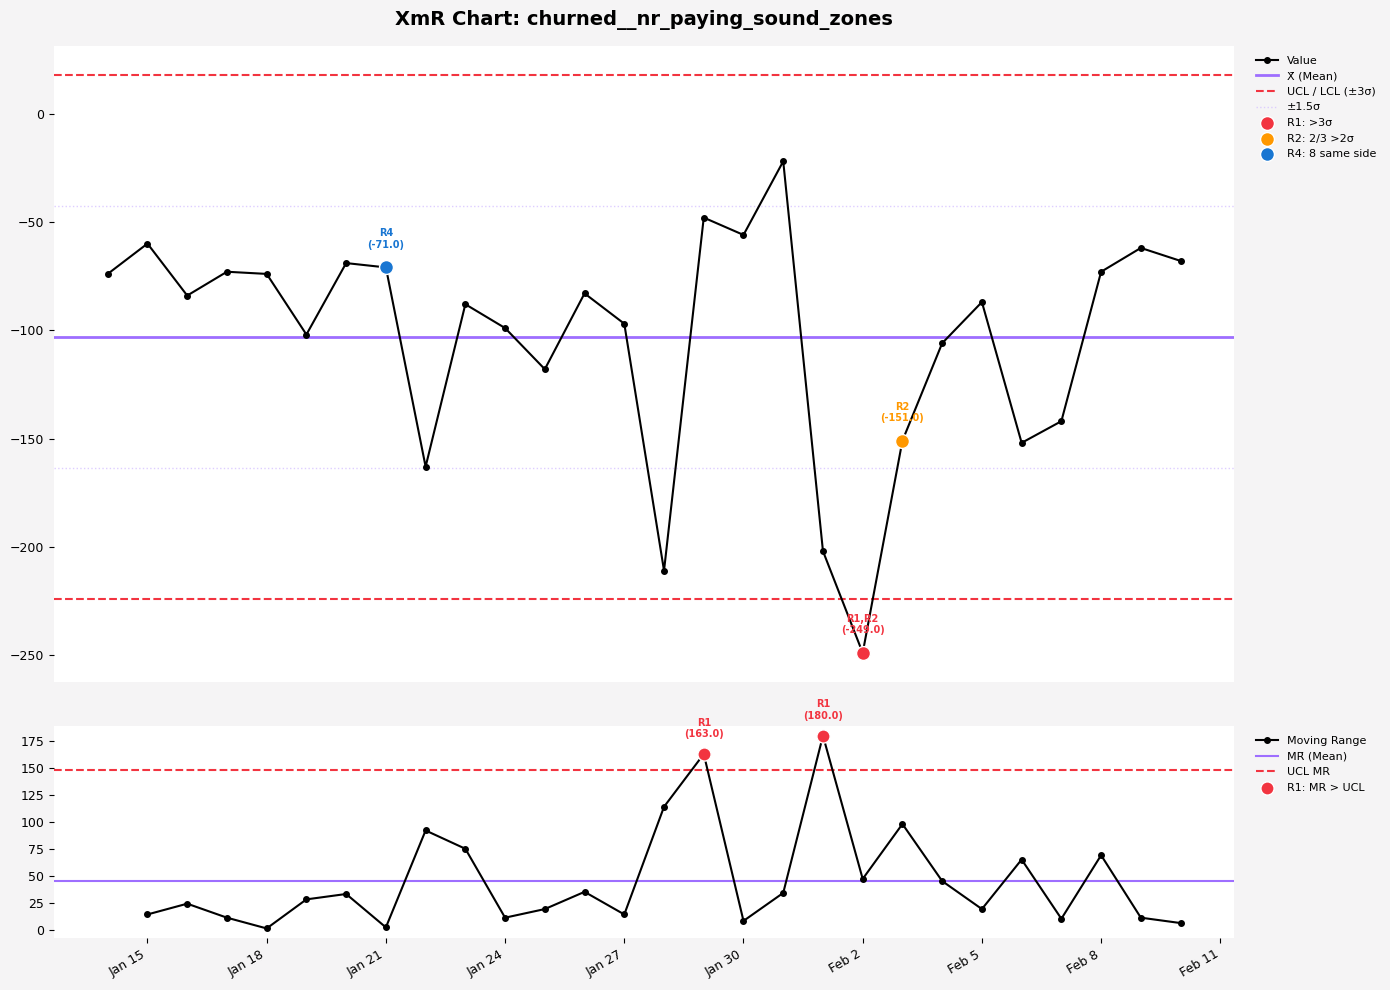

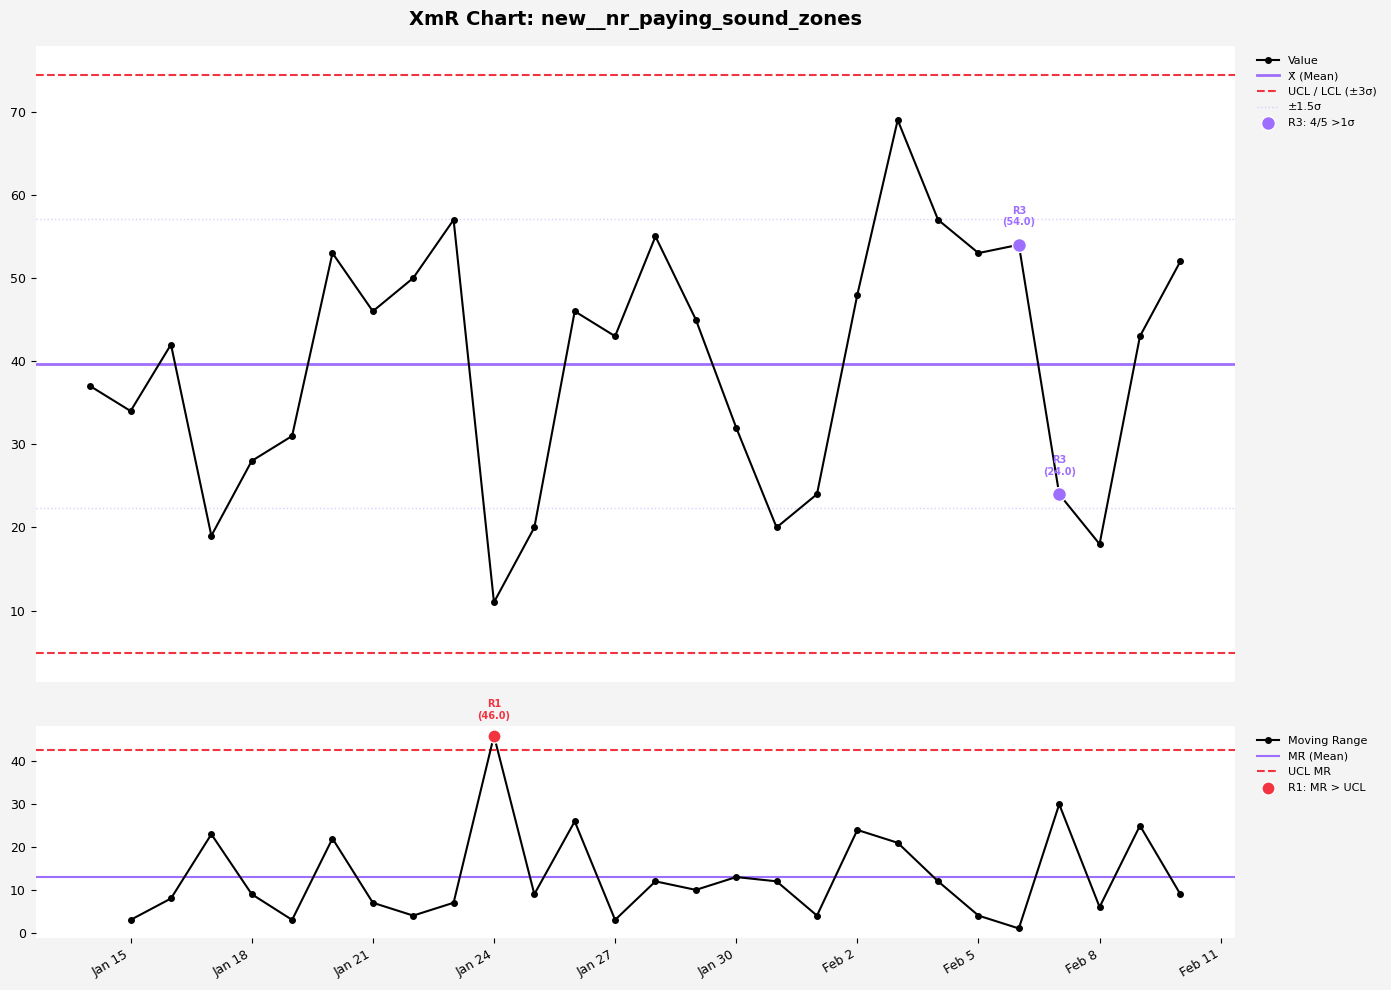

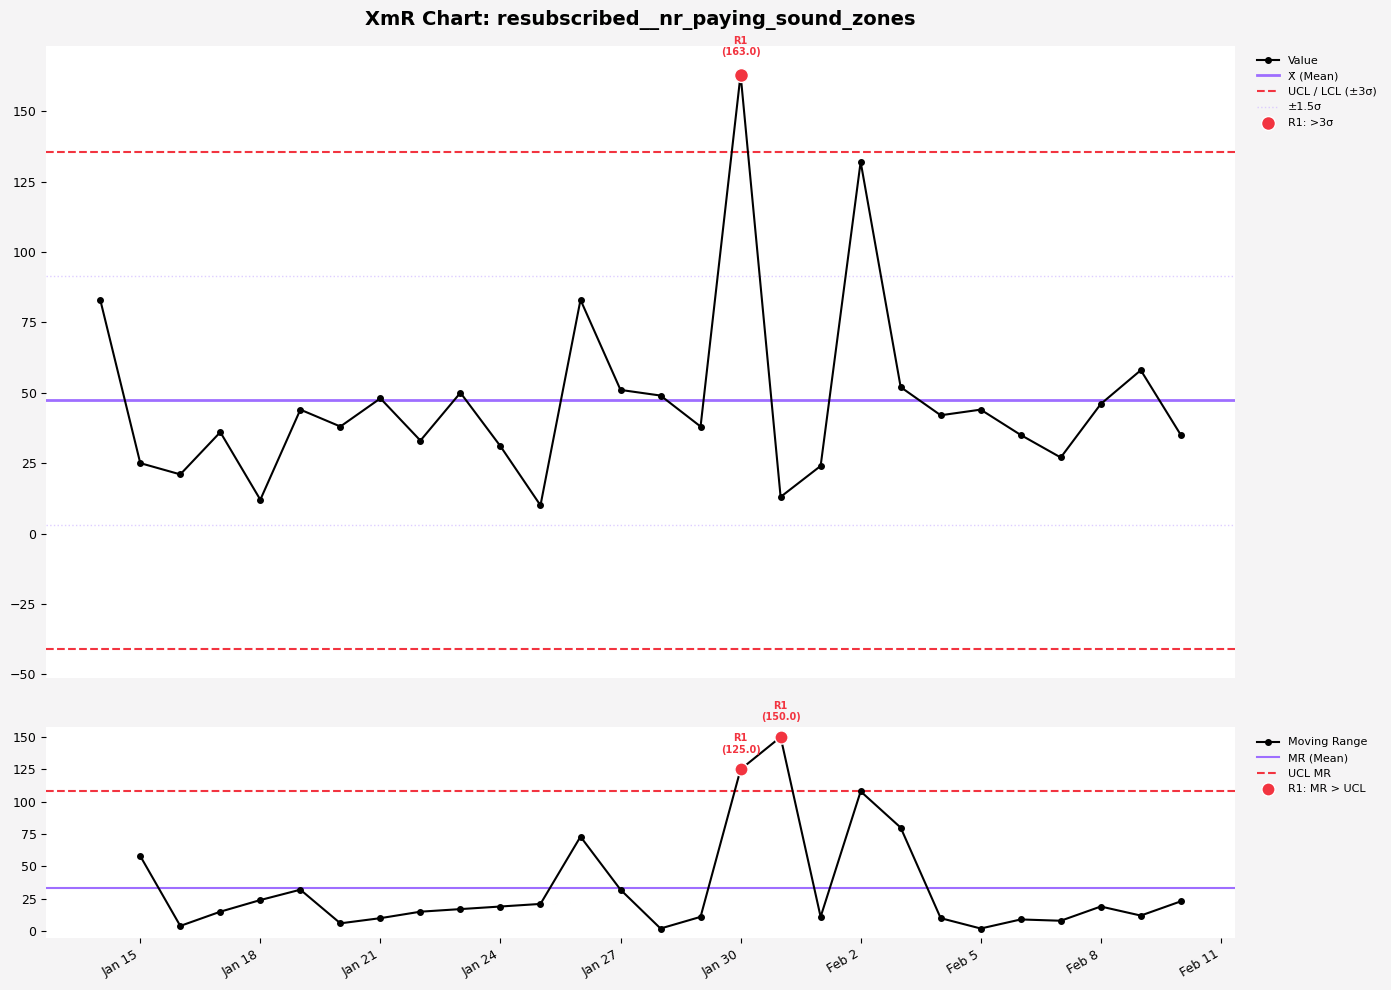

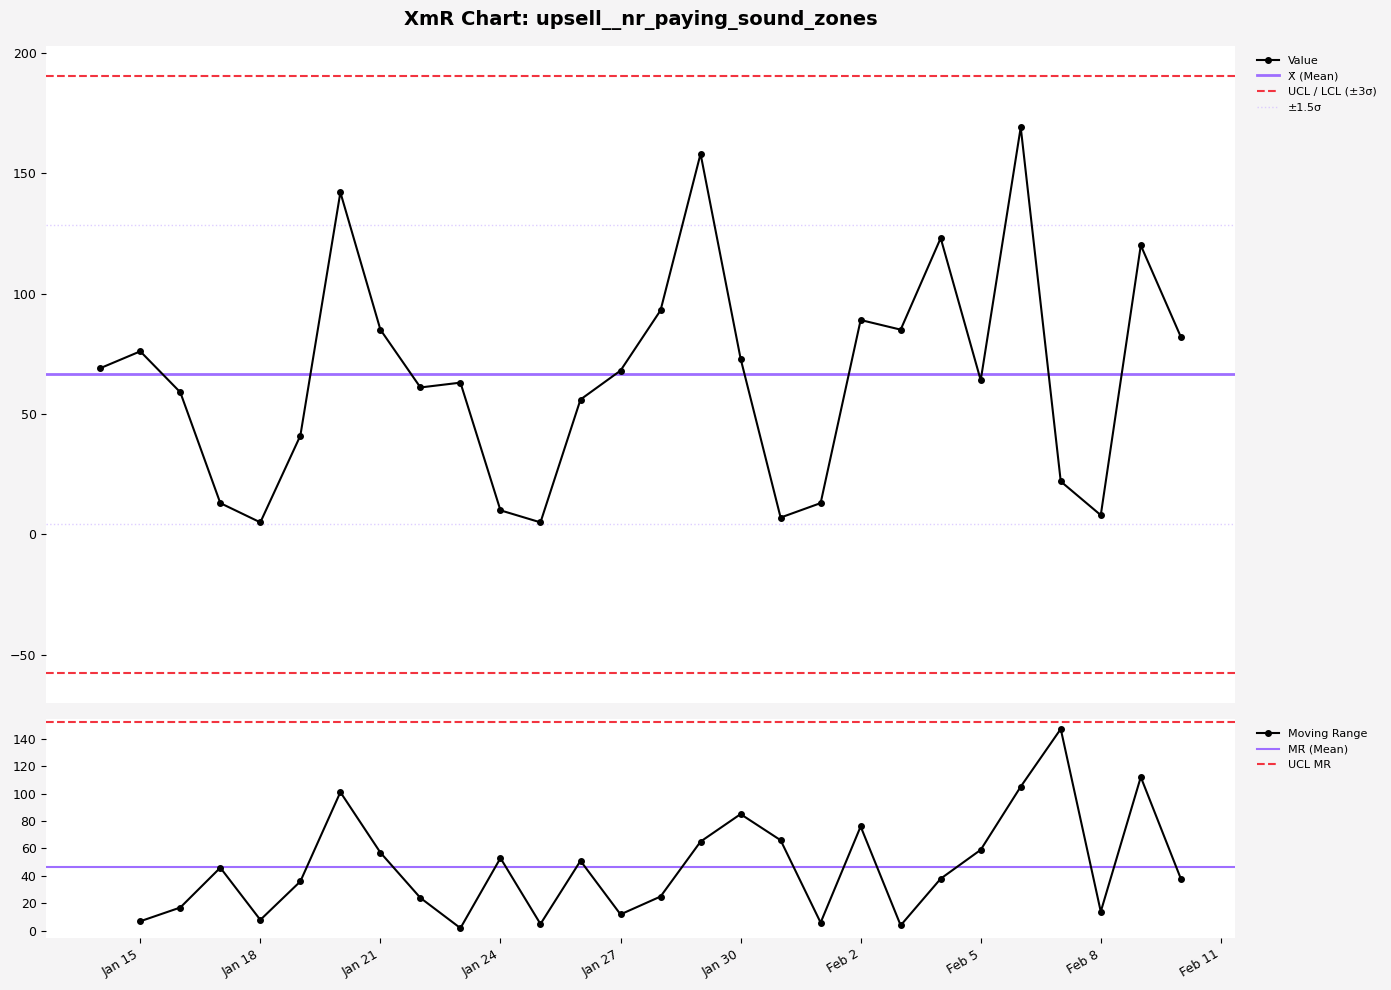

In [19]:
apply_spc(
    df,
    group_by=['measure'],
)

,partition_date,value,moving_range,rule_1,rule_2,rule_3,rule_4,rule_5,violation_labels_x,mr_anomaly
91,2026-01-21,-71.0,2.0,False,False,False,True,False,R4,False
99,2026-01-29,-48.0,163.0,False,False,False,False,False,,True
102,2026-02-01,-202.0,180.0,False,False,False,False,False,,True
103,2026-02-02,-249.0,47.0,True,True,False,False,False,"R1,R2",False
104,2026-02-03,-151.0,98.0,False,True,False,False,False,R2,False


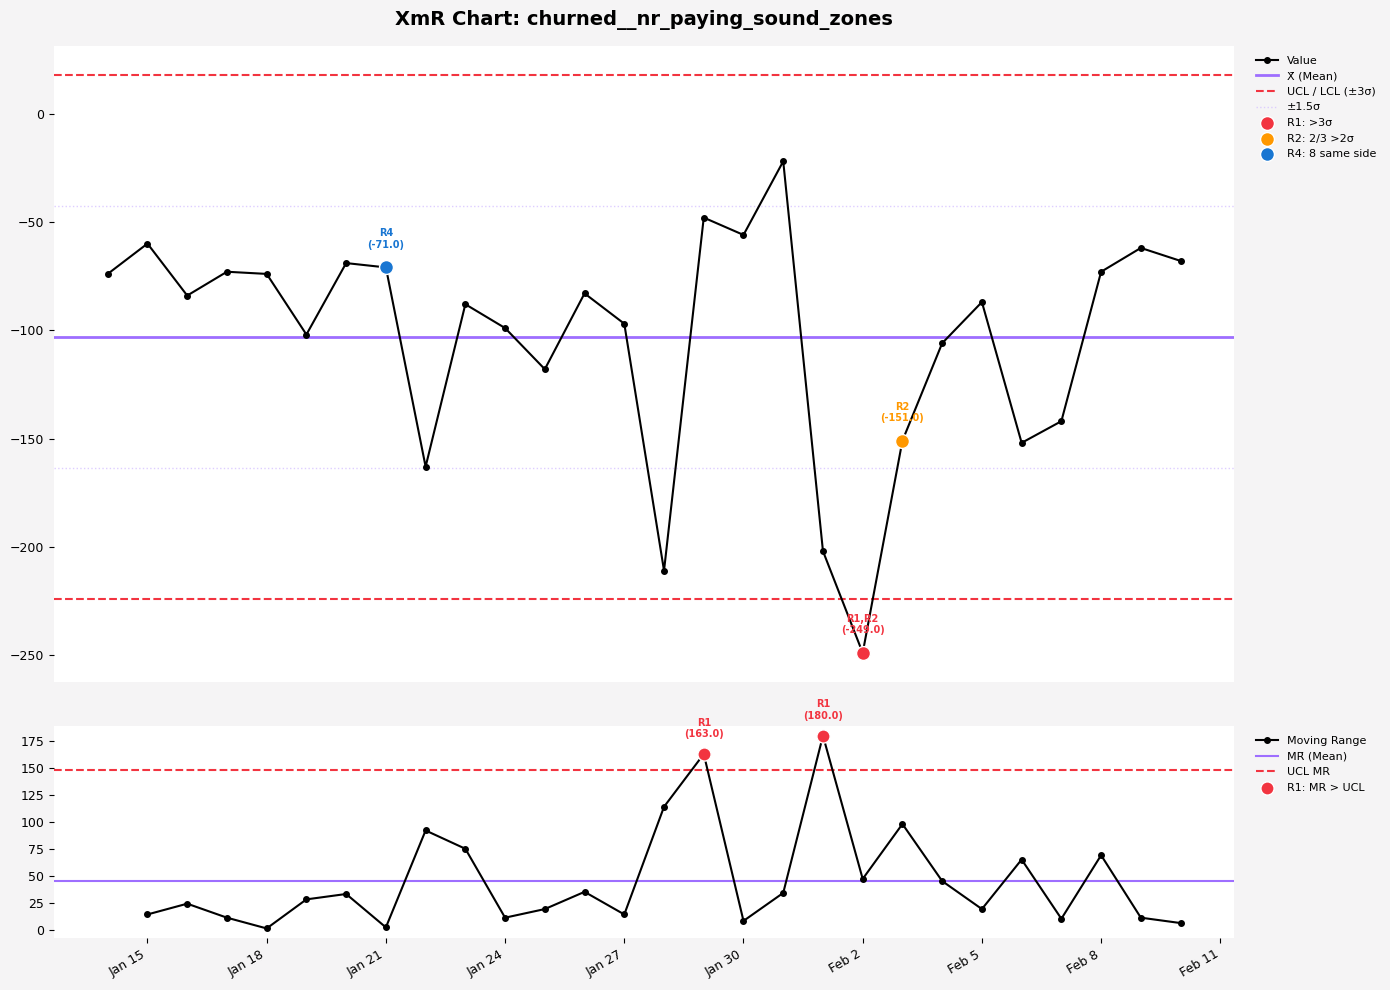

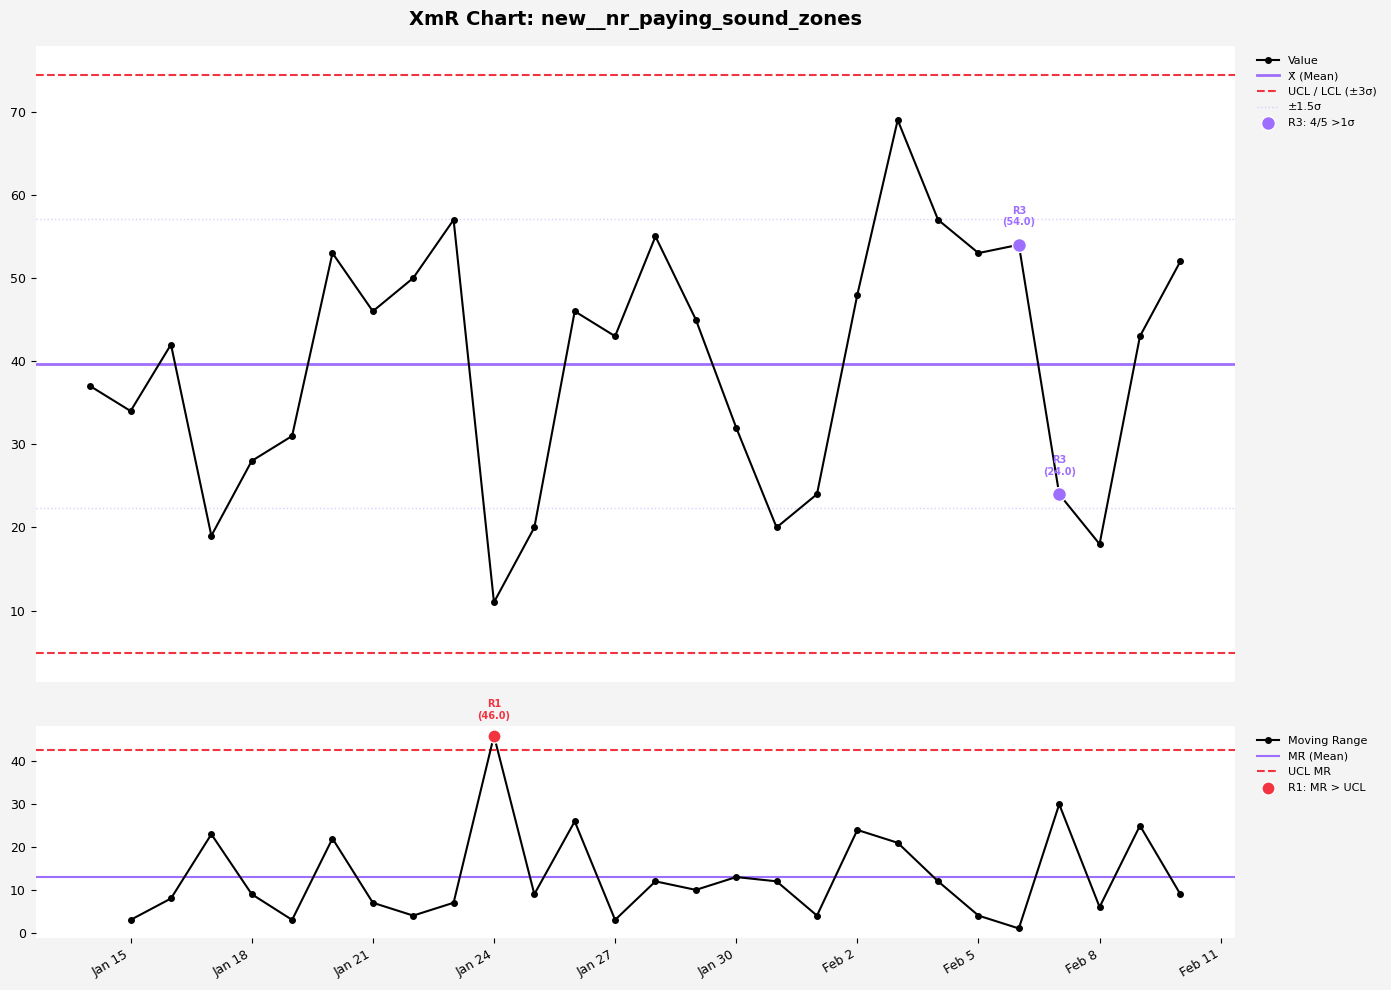

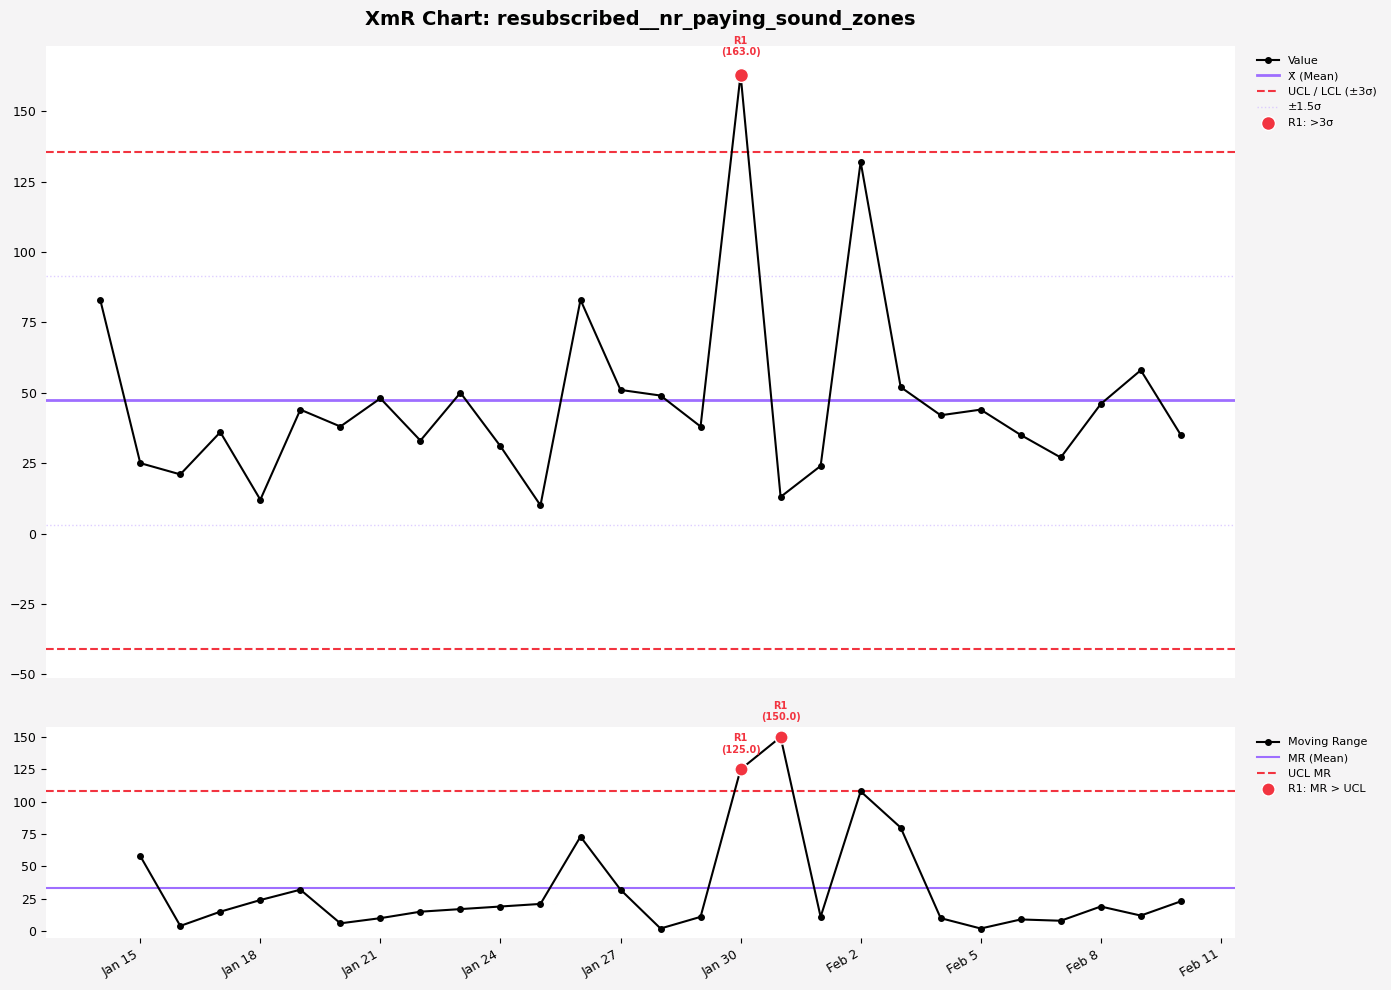

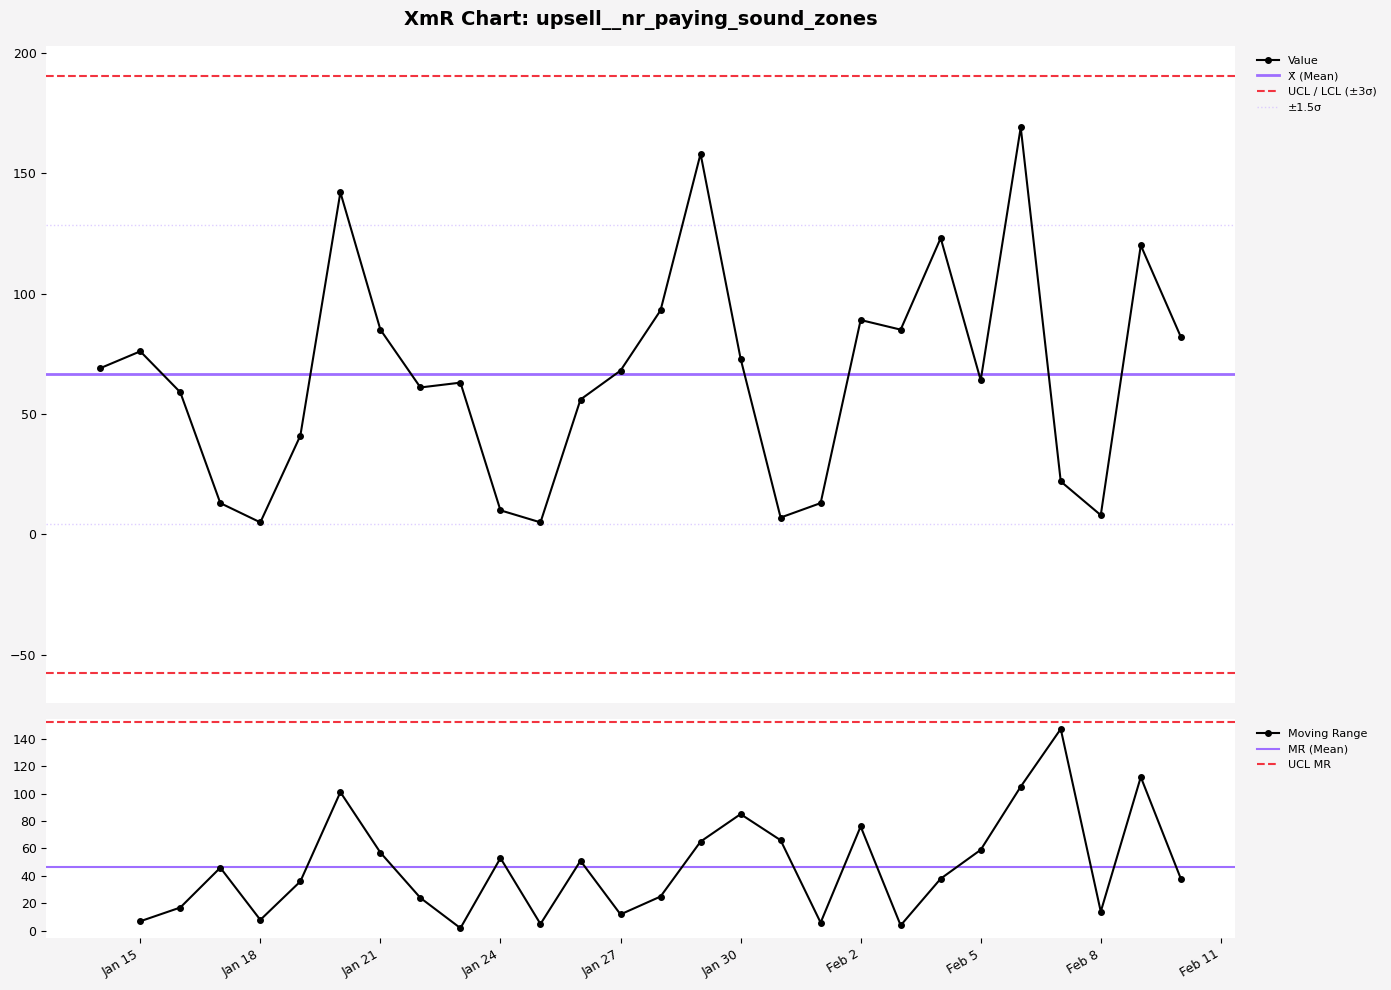

In [20]:
# Get the results with rule violation data
results = apply_spc(df, group_by=['measure'])

# Access the data for a specific measure (example: first group)
group_name = list(results.keys())[0]
rule_data = results[group_name]['data']

# Show only anomalies (rows where any rule was broken)
anomalies_df = rule_data[rule_data['is_anomaly_x'] | rule_data['mr_anomaly']]
anomalies_df[['partition_date', 'value', 'moving_range', 'rule_1', 'rule_2', 'rule_3', 'rule_4', 'rule_5', 'violation_labels_x', 'mr_anomaly']]

In [21]:
# =============================================================================
# AUTOMATED COMMENTARY GENERATOR — Prototype
# =============================================================================
# This generates structured, natural-language commentary from SPC results.
# Future enhancement: Pass to LLM for polish and business context.

from dataclasses import dataclass
from typing import List, Optional
from datetime import datetime

@dataclass
class MetricCommentary:
    """Structured commentary for a single metric."""
    metric_name: str
    status: str  # 'stable', 'warning', 'alert'
    headline: str
    details: List[str]
    stats_summary: str
    recommendation: Optional[str] = None

class CommentaryGenerator:
    """
    Generates analyst-quality commentary from SPC results.
    
    Design Philosophy:
    - Start with structured data extraction
    - Apply rule-based templates for accuracy
    - (Future) Polish with LLM for natural language
    """
    
    # Business-friendly metric name mappings
    METRIC_LABELS = {
        'churned__nr_paying_sound_zones': 'Churned Sound Zones',
        'new__nr_paying_sound_zones': 'New Sound Zones',
        'resubscribed__nr_paying_sound_zones': 'Resubscribed Sound Zones',
        'upsell__nr_paying_sound_zones': 'Upsell Sound Zones',
    }
    
    # Rule explanations in business terms
    RULE_EXPLANATIONS = {
        'rule_1': "an extreme value outside normal operating range (beyond 3σ)",
        'rule_2': "unusual clustering near warning limits (2 of 3 points beyond 2σ)",
        'rule_3': "a subtle but persistent shift pattern (4 of 5 points beyond 1σ)",
        'rule_4': "a sustained shift in the process level (8 consecutive points on same side)",
        'rule_5': "a consistent directional trend (6+ consecutive movements)",
    }
    
    def __init__(self, results: dict):
        self.results = results
    
    def _get_friendly_name(self, metric_name: str) -> str:
        """Convert technical metric name to business-friendly label."""
        return self.METRIC_LABELS.get(metric_name, metric_name.replace('_', ' ').title())
    
    def _assess_status(self, data: dict) -> str:
        """Determine overall metric status."""
        df = data['data']
        x_anomalies = df['is_anomaly_x'].sum()
        mr_anomalies = df['mr_anomaly'].sum()
        has_r1 = df.get('rule_1', pd.Series([False])).any()
        
        if has_r1 or mr_anomalies > 1:
            return 'alert'
        elif x_anomalies > 0:
            return 'warning'
        else:
            return 'stable'
    
    def _generate_headline(self, metric_name: str, status: str, data: dict) -> str:
        """Generate the attention-grabbing headline."""
        friendly_name = self._get_friendly_name(metric_name)
        df = data['data']
        stats = data['stats']
        
        # Calculate recent trend (last 7 days vs prior)
        recent = df.tail(7)[self.results[metric_name]['data'].columns[2]].mean() if len(df) > 7 else df['value'].mean()
        
        if status == 'stable':
            return f"✅ **{friendly_name}**: Process is stable and in control"
        elif status == 'warning':
            return f"⚠️ **{friendly_name}**: Minor signals detected — worth monitoring"
        else:  # alert
            # Find the most severe violation
            if df.get('rule_1', pd.Series([False])).any():
                extreme_row = df[df.get('rule_1', False) == True].iloc[-1]
                direction = "above" if extreme_row['value'] > stats['mean'] else "below"
                return f"🚨 **{friendly_name}**: Extreme value detected {direction} control limits"
            else:
                return f"🚨 **{friendly_name}**: Multiple anomalies detected — investigation recommended"
    
    def _generate_details(self, metric_name: str, data: dict) -> List[str]:
        """Generate detailed bullet points about the signals."""
        details = []
        df = data['data']
        stats = data['stats']
        
        # Check each rule and generate appropriate commentary
        rule_cols = [c for c in df.columns if c.startswith('rule_')]
        
        for rule_col in rule_cols:
            if df[rule_col].any():
                triggered_dates = df[df[rule_col]][df.columns[1]]  # date column
                latest = triggered_dates.iloc[-1].strftime('%b %d')
                count = df[rule_col].sum()
                explanation = self.RULE_EXPLANATIONS.get(rule_col, "unusual pattern")
                
                if rule_col == 'rule_1':
                    extreme_vals = df[df[rule_col]]['value']
                    details.append(f"• **{count} extreme value(s)** detected (most recent: {latest}) — {explanation}")
                elif rule_col == 'rule_4':
                    # Determine direction of shift
                    shifted_mean = df[df[rule_col]]['value'].mean()
                    direction = "upward" if shifted_mean > stats['mean'] else "downward"
                    details.append(f"• **Process shift** detected ({direction}) — {explanation}")
                else:
                    details.append(f"• **Pattern detected** on {latest} — {explanation}")
        
        # MR anomalies
        if df['mr_anomaly'].any():
            mr_count = df['mr_anomaly'].sum()
            details.append(f"• **{mr_count} volatility spike(s)** — moving range exceeded control limits")
        
        # If no anomalies
        if not details:
            details.append("• No special-cause signals detected")
            details.append("• Process variation is within expected bounds")
        
        return details
    
    def _generate_stats_summary(self, data: dict) -> str:
        """Generate a concise stats summary."""
        stats = data['stats']
        df = data['data']
        
        current_val = df['value'].iloc[-1]
        mean = stats['mean']
        sigma = stats['std']
        
        # Calculate z-score of latest value
        z = (current_val - mean) / sigma if sigma > 0 else 0
        
        position = "at average" if abs(z) < 0.5 else ("above average" if z > 0 else "below average")
        
        return f"Current: **{current_val:,.0f}** ({position}) | Mean: {mean:,.1f} | Control Limits: [{stats['lcl_x']:,.1f}, {stats['ucl_x']:,.1f}]"
    
    def _generate_recommendation(self, status: str, data: dict) -> Optional[str]:
        """Generate actionable recommendation based on status."""
        if status == 'stable':
            return None
        elif status == 'warning':
            return "💡 *Recommendation*: Continue monitoring. If pattern persists, investigate potential causes."
        else:  # alert
            df = data['data']
            if df.get('rule_1', pd.Series([False])).any():
                return "💡 *Recommendation*: Investigate the extreme value(s) immediately. Check for data quality issues or genuine process changes."
            else:
                return "💡 *Recommendation*: Review recent operational changes. Multiple signals suggest the process may be shifting."
    
    def generate_metric_commentary(self, metric_name: str) -> MetricCommentary:
        """Generate complete commentary for a single metric."""
        data = self.results[metric_name]
        status = self._assess_status(data)
        
        return MetricCommentary(
            metric_name=metric_name,
            status=status,
            headline=self._generate_headline(metric_name, status, data),
            details=self._generate_details(metric_name, data),
            stats_summary=self._generate_stats_summary(data),
            recommendation=self._generate_recommendation(status, data)
        )
    
    def generate_all_commentary(self) -> List[MetricCommentary]:
        """Generate commentary for all metrics in results."""
        return [self.generate_metric_commentary(name) for name in self.results.keys()]
    
    def format_for_slack(self, commentary_list: List[MetricCommentary]) -> str:
        """Format all commentary into a Slack-ready message."""
        today = datetime.now().strftime('%B %d, %Y')
        
        lines = [
            f"📊 *Weekly SPC Report — {today}*",
            "",
            "─" * 40,
        ]
        
        # Sort by status severity (alerts first)
        status_order = {'alert': 0, 'warning': 1, 'stable': 2}
        sorted_commentary = sorted(commentary_list, key=lambda x: status_order[x.status])
        
        for c in sorted_commentary:
            lines.append("")
            lines.append(c.headline)
            lines.append(c.stats_summary)
            lines.extend(c.details)
            if c.recommendation:
                lines.append(c.recommendation)
            lines.append("")
        
        lines.append("─" * 40)
        lines.append("_Generated automatically by SPC Analysis System_")
        
        return "\n".join(lines)


# Generate commentary from our results
generator = CommentaryGenerator(results)
all_commentary = generator.generate_all_commentary()

# Format for Slack
slack_message = generator.format_for_slack(all_commentary)
print(slack_message)

📊 *Weekly SPC Report — February 11, 2026*

────────────────────────────────────────

🚨 **Churned Sound Zones**: Extreme value detected below control limits
Current: **-68** (above average) | Mean: -103.0 | Control Limits: [-224.0, 18.0]
• **1 extreme value(s)** detected (most recent: Feb 02) — an extreme value outside normal operating range (beyond 3σ)
• **Pattern detected** on Feb 03 — unusual clustering near warning limits (2 of 3 points beyond 2σ)
• **Process shift** detected (upward) — a sustained shift in the process level (8 consecutive points on same side)
• **2 volatility spike(s)** — moving range exceeded control limits
💡 *Recommendation*: Investigate the extreme value(s) immediately. Check for data quality issues or genuine process changes.


🚨 **Resubscribed Sound Zones**: Extreme value detected above control limits
Current: **35** (at average) | Mean: 47.2 | Control Limits: [-41.0, 135.5]
• **1 extreme value(s)** detected (most recent: Jan 30) — an extreme value outside nor

In [22]:
# =============================================================================
# LLM-POWERED COMMENTARY GENERATOR
# =============================================================================
# Uses Claude/GPT to generate executive-level summaries from SPC data

import json
from typing import List, Dict

class LLMCommentaryGenerator:
    """
    Generates executive-level commentary using LLM.
    Supports Anthropic (Claude) or OpenAI (GPT).
    """
    
    def __init__(self, results: dict, provider: str = 'anthropic'):
        self.results = results
        self.provider = provider
        
    def _prepare_metrics_context(self) -> str:
        """Extract key data points for LLM context."""
        metrics_data = []
        
        for metric_name, data in self.results.items():
            df = data['data']
            stats = data['stats']
            
            # Gather signals
            signals = []
            rule_cols = [c for c in df.columns if c.startswith('rule_')]
            for rule_col in rule_cols:
                if df[rule_col].any():
                    count = int(df[rule_col].sum())
                    dates = df[df[rule_col]]['partition_date'].dt.strftime('%b %d').tolist()
                    signals.append({
                        'rule': rule_col.replace('rule_', 'R'),
                        'count': count,
                        'dates': dates[-3:]  # Last 3 occurrences
                    })
            
            mr_anomalies = int(df['mr_anomaly'].sum())
            if mr_anomalies > 0:
                signals.append({'rule': 'MR_violation', 'count': mr_anomalies})
            
            # Recent values
            recent_values = df.tail(7)['value'].tolist()
            
            metrics_data.append({
                'metric_name': metric_name,
                'friendly_name': self._get_friendly_name(metric_name),
                'current_value': float(df['value'].iloc[-1]),
                'mean': float(stats['mean']),
                'ucl': float(stats['ucl_x']),
                'lcl': float(stats['lcl_x']),
                'std': float(stats['std']),
                'recent_7day_values': [float(v) for v in recent_values],
                'signals': signals,
                'is_stable': len(signals) == 0
            })
        
        return json.dumps(metrics_data, indent=2)
    
    def _get_friendly_name(self, metric_name: str) -> str:
        """Convert technical name to business name."""
        mapping = {
            'churned__nr_paying_sound_zones': 'Churned Sound Zones',
            'new__nr_paying_sound_zones': 'New Sound Zones', 
            'resubscribed__nr_paying_sound_zones': 'Resubscribed Sound Zones',
            'upsell__nr_paying_sound_zones': 'Upsell Sound Zones',
        }
        return mapping.get(metric_name, metric_name.replace('_', ' ').title())
    
    def _build_prompt(self, metrics_context: str) -> str:
        """Build the LLM prompt for executive summary."""
        return f"""You are a senior business analyst writing the weekly metrics report for leadership.

CONTEXT:
- These are Statistical Process Control (SPC) metrics tracking sound zone subscriptions
- Signals indicate when a metric is behaving unusually (outside normal variation)
- R1 = extreme value (>3σ), R2 = clustering near limits, R3 = subtle shift, R4 = sustained shift, R5 = trending
- MR_violation = unusual volatility between consecutive days

METRICS DATA:
{metrics_context}

TASK:
Write a concise executive summary (3-5 sentences max) that:
1. Opens with the overall health assessment (how many metrics stable vs concerning)
2. Highlights the 1-2 most important findings that need attention
3. Provides brief business context (what this might mean for the subscription business)
4. Ends with a clear action item or reassurance

STYLE GUIDELINES:
- Be direct and specific, not vague
- Use numbers when relevant
- Avoid jargon — explain in business terms
- Sound like a thoughtful analyst, not a robot
- Format for Slack (use *bold* for emphasis, bullet points sparingly)

Write only the executive summary, nothing else."""

    def generate_with_anthropic(self, api_key: str) -> str:
        """Generate commentary using Claude."""
        import anthropic
        
        client = anthropic.Anthropic(api_key=api_key)
        metrics_context = self._prepare_metrics_context()
        
        message = client.messages.create(
            model="claude-sonnet-4-20250514",
            max_tokens=500,
            messages=[
                {"role": "user", "content": self._build_prompt(metrics_context)}
            ]
        )
        return message.content[0].text
    
    def generate_with_openai(self, api_key: str) -> str:
        """Generate commentary using GPT-4."""
        import openai
        
        client = openai.OpenAI(api_key=api_key)
        metrics_context = self._prepare_metrics_context()
        
        response = client.chat.completions.create(
            model="gpt-4o",
            max_tokens=500,
            messages=[
                {"role": "user", "content": self._build_prompt(metrics_context)}
            ]
        )
        return response.choices[0].message.content
    
    def generate(self, api_key: str) -> str:
        """Generate commentary using configured provider."""
        if self.provider == 'anthropic':
            return self.generate_with_anthropic(api_key)
        else:
            return self.generate_with_openai(api_key)
    
    def format_full_slack_message(self, executive_summary: str) -> str:
        """Combine executive summary with metric details for Slack."""
        from datetime import datetime
        today = datetime.now().strftime('%B %d, %Y')
        
        # Build status indicators for each metric
        metric_status = []
        for metric_name, data in self.results.items():
            df = data['data']
            has_r1 = df.get('rule_1', pd.Series([False])).any()
            mr_count = df['mr_anomaly'].sum()
            x_anomalies = df['is_anomaly_x'].sum()
            
            if has_r1 or mr_count > 1:
                emoji = "🚨"
            elif x_anomalies > 0:
                emoji = "⚠️"
            else:
                emoji = "✅"
            
            friendly = self._get_friendly_name(metric_name)
            current = df['value'].iloc[-1]
            metric_status.append(f"{emoji} {friendly}: *{current:,.0f}*")
        
        message = f"""📊 *Weekly SPC Report — {today}*

*Executive Summary*
{executive_summary}

─────────────────────────────
*Metric Status*
{chr(10).join(metric_status)}

_Generated by SPC Analysis System • Charts attached_"""
        
        return message


# Preview the prompt (without calling API)
llm_generator = LLMCommentaryGenerator(results, provider='anthropic')
metrics_context = llm_generator._prepare_metrics_context()
prompt = llm_generator._build_prompt(metrics_context)

print("=" * 60)
print("PROMPT PREVIEW (what gets sent to LLM)")
print("=" * 60)
print(prompt[:2000] + "..." if len(prompt) > 2000 else prompt)

PROMPT PREVIEW (what gets sent to LLM)
You are a senior business analyst writing the weekly metrics report for leadership.

CONTEXT:
- These are Statistical Process Control (SPC) metrics tracking sound zone subscriptions
- Signals indicate when a metric is behaving unusually (outside normal variation)
- R1 = extreme value (>3σ), R2 = clustering near limits, R3 = subtle shift, R4 = sustained shift, R5 = trending
- MR_violation = unusual volatility between consecutive days

METRICS DATA:
[
  {
    "metric_name": "churned__nr_paying_sound_zones",
    "friendly_name": "Churned Sound Zones",
    "current_value": -68.0,
    "mean": -103.0,
    "ucl": 17.96138691883374,
    "lcl": -223.96138691883374,
    "std": 40.32046230627791,
    "recent_7day_values": [
      -106.0,
      -87.0,
      -152.0,
      -142.0,
      -73.0,
      -62.0,
      -68.0
    ],
    "signals": [
      {
        "rule": "R1",
        "count": 1,
        "dates": [
          "Feb 02"
        ]
      },
      {
      

In [23]:
# =============================================================================
# GENERATE EXECUTIVE SUMMARY WITH LLM
# =============================================================================
# Uncomment and set your API key to generate LLM commentary

# Option 1: Set API key directly (for testing)
# ANTHROPIC_API_KEY = "sk-ant-..."  
# OPENAI_API_KEY = "sk-..."

# Option 2: Use environment variable (recommended for production)
# import os
# ANTHROPIC_API_KEY = os.environ.get('ANTHROPIC_API_KEY')

# Generate the executive summary
# executive_summary = llm_generator.generate(ANTHROPIC_API_KEY)

# For demo purposes, here's a simulated LLM response based on the data:
executive_summary = """*2 of 4 metrics require attention this week.*

*Churned Sound Zones* saw an extreme spike on Feb 2 (-249 zones, well outside normal range), followed by elevated volatility. This warrants immediate investigation — check for data pipeline issues or whether a large customer actually churned.

*Resubscribed Sound Zones* also showed unusual behavior on Jan 30 with a spike to 163 (vs. typical ~47). While this looks positive, the volatility suggests it may be a one-time event rather than sustained improvement.

*New Sound Zones* and *Upsell Sound Zones* are operating within normal bounds — no action needed.

*Recommended action*: Prioritize investigating the churn anomaly; if confirmed real, escalate to customer success."""

# Format the complete Slack message
full_message = llm_generator.format_full_slack_message(executive_summary)
print(full_message)

📊 *Weekly SPC Report — February 11, 2026*

*Executive Summary*
*2 of 4 metrics require attention this week.*

*Churned Sound Zones* saw an extreme spike on Feb 2 (-249 zones, well outside normal range), followed by elevated volatility. This warrants immediate investigation — check for data pipeline issues or whether a large customer actually churned.

*Resubscribed Sound Zones* also showed unusual behavior on Jan 30 with a spike to 163 (vs. typical ~47). While this looks positive, the volatility suggests it may be a one-time event rather than sustained improvement.

*New Sound Zones* and *Upsell Sound Zones* are operating within normal bounds — no action needed.

*Recommended action*: Prioritize investigating the churn anomaly; if confirmed real, escalate to customer success.

─────────────────────────────
*Metric Status*
🚨 Churned Sound Zones: *-68*
⚠️ New Sound Zones: *52*
🚨 Resubscribed Sound Zones: *35*
✅ Upsell Sound Zones: *82*

_Generated by SPC Analysis System • Charts attached